In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


# User input

In [3]:
adata_input = '/storage/groups/ml01/datasets/projects/20190117_Wurst_Demuxlet_malte.luecken/ipsc_ipd_cell_lines_raw.h5ad'

adata_output = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_cell_lines_preproc.h5ad'

adata_output_internal = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_cell_lines_int_preproc.h5ad'
adata_output_ko = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_cell_lines_ko_preproc.h5ad'

cc_genes_tirosh = '/home/icb/malte.luecken/single-cell-tutorial/Tirosh_cell_cycle_genes_human.txt'

# Start R session

In [5]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

# Read in data

In [6]:
adata = sc.read(adata_input)

# Check dataset

In [7]:
#Check dataset stats
adata
adata.obs['Lane'].value_counts()
adata.obs['Demux_state'].value_counts()
adata.obs['Donor'].value_counts()
pd.crosstab(adata.obs.Lane, adata.obs.Donor)

AnnData object with n_obs × n_vars = 10313 × 58735 
    obs: 'Demux_state', 'Donor', 'Lane'

4    2160
6    2065
5    2049
3    1370
1    1335
2    1334
Name: Lane, dtype: int64

SNG    10313
Name: Demux_state, dtype: int64

17/5_KLON2    3731
C4_KLON1_1    2864
Delta40.7     2543
TUE3_1        1175
Name: Donor, dtype: int64

Donor  17/5_KLON2  C4_KLON1_1  Delta40.7  TUE3_1
Lane                                            
1               0         956          0     379
2               0         953          0     381
3               0         955          0     415
4            1289           0        871       0
5            1219           0        830       0
6            1223           0        842       0

# Rename cell lines

In [48]:
adata.obs.Donor.cat.categories
adata.rename_categories('Donor', ['internal_1', 'internal_2', 'Pink1_ko', 'Pink1_ko_ctrl'])

Index(['17/5_KLON2', 'C4_KLON1_1', 'Delta40.7', 'TUE3_1'], dtype='object')

In [49]:
adata.obs.Donor.value_counts()

Pink1_mut         3718
Pink1_mut_ctrl    2851
Pink1_ko          2529
Pink1_ko_ctrl     1142
Name: Donor, dtype: int64

# Quality Control

In [8]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

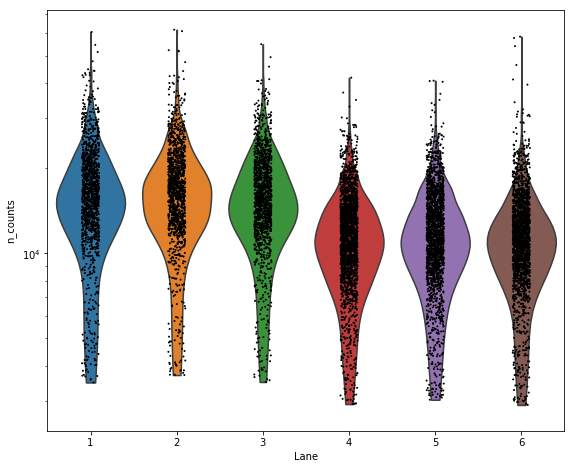

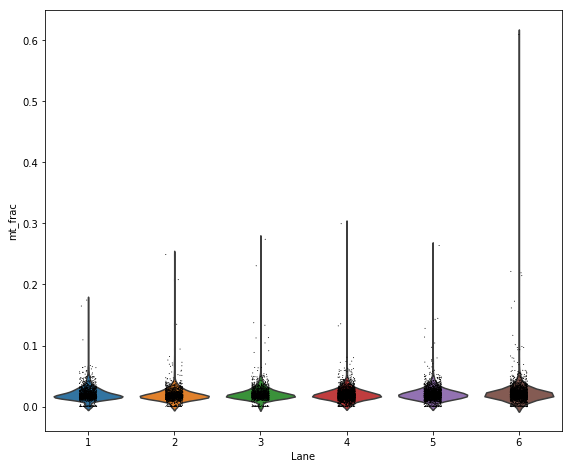

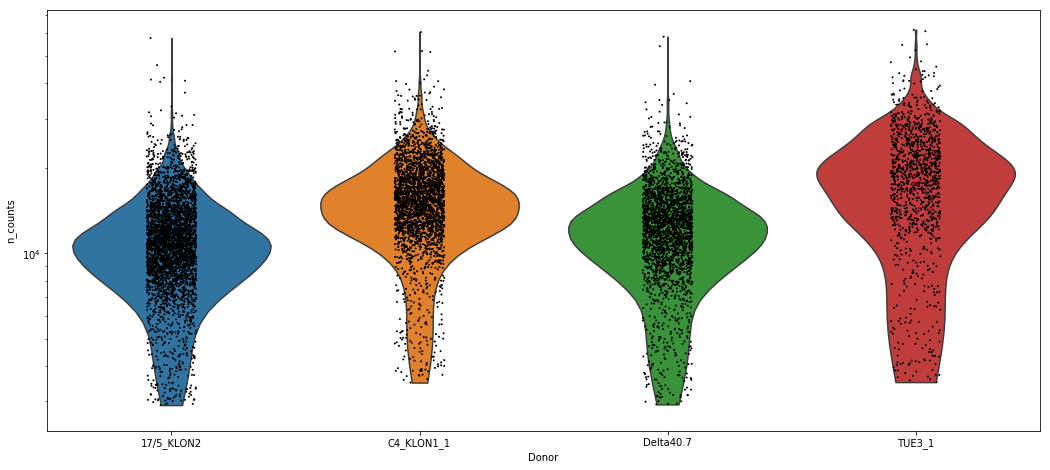

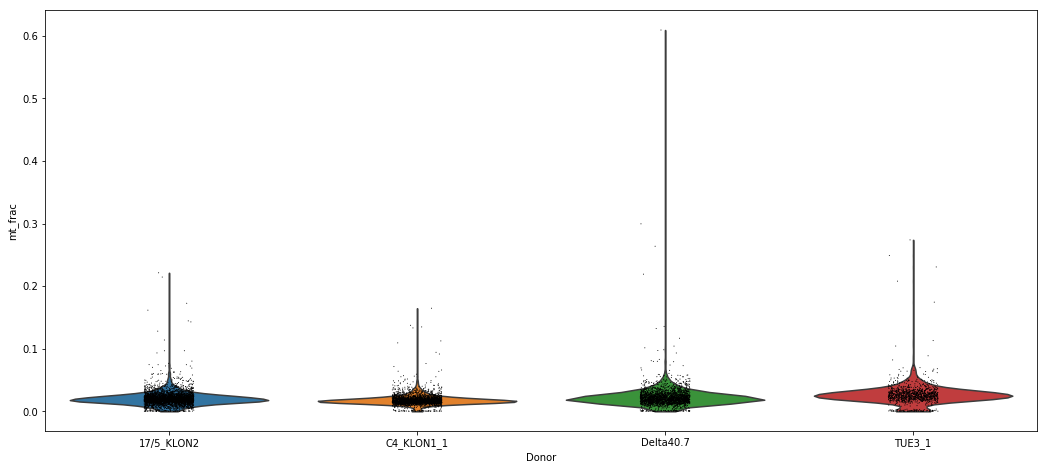

In [9]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='Lane', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='Lane')

plt.rcParams['figure.figsize']=(14,8) #rescale figures
t3 = sc.pl.violin(adata, 'n_counts', groupby='Donor', size=2, log=True, cut=0)
t4 = sc.pl.violin(adata, 'mt_frac', groupby='Donor', cut=0)
plt.rcParams['figure.figsize']=(8,8) #rescale figures

Data are broadly consistent across lanes, and Donors. Lanes 4, 5, and 6 have a few more cells and slightly lower counts. This may be a biological effect due to separation of cell lines over lanes. TUE3_1 is a bit of an outlier line with far fewer cells, but higher counts per cell, and potentially a higher mt_frac.

We could filter cells and genes jointly given the above results, however we will filter them separately to be prudent.

In [10]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 160))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

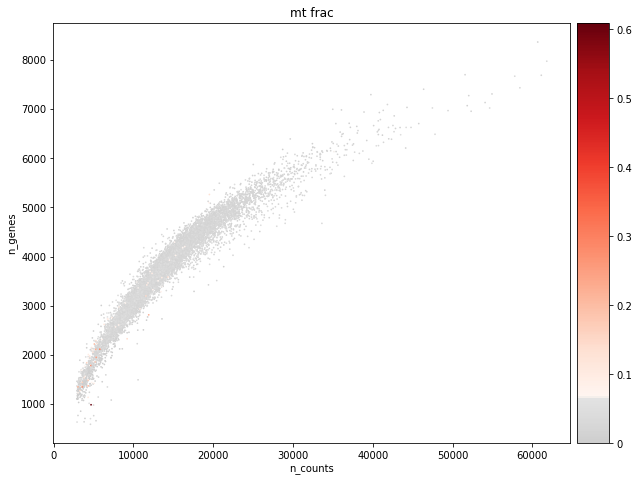

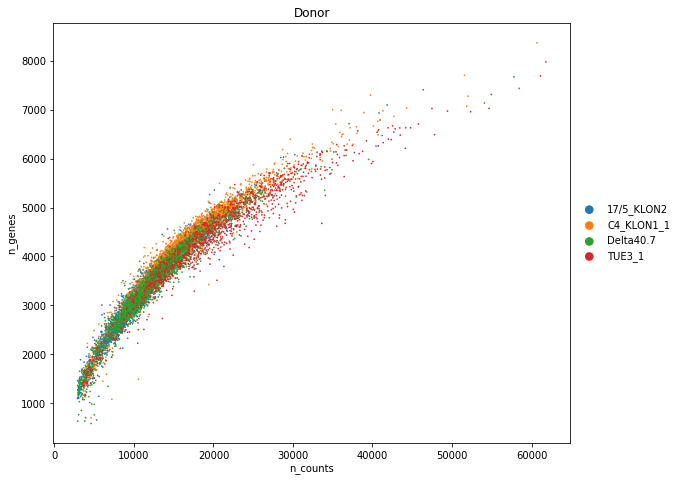

/home/icb/malte.luecken/new_anndata/anndata/anndata/core/anndata.py:1335: UserWarning: Initializing view as actual.
  warnings.warn("Initializing view as actual.")


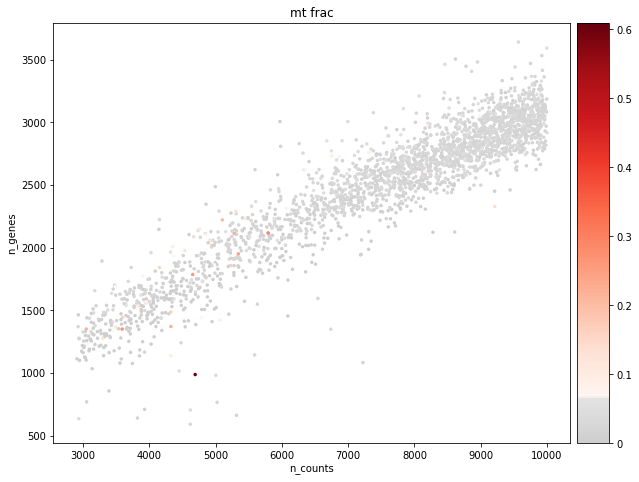

In [11]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', color_map=mymap)
p1_1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='Donor')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', color_map=mymap)


Here it looks like n_genes < 1000 should be filtered out, and counts are all fine.

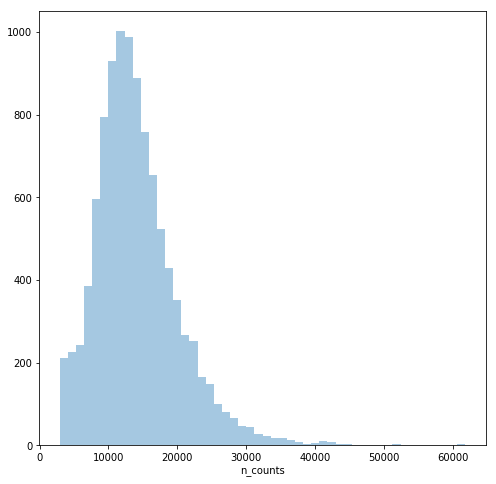

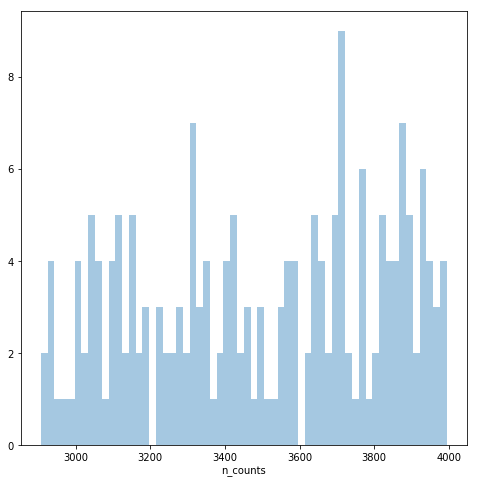

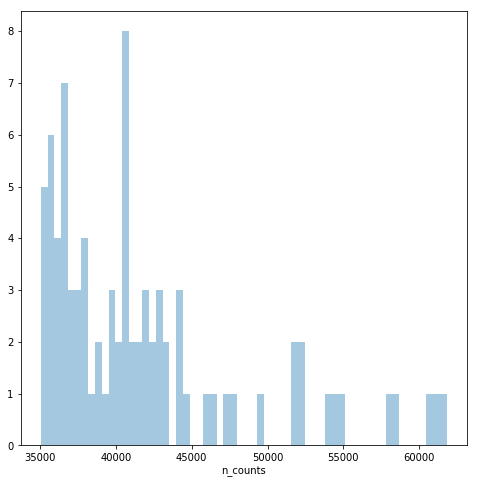

In [12]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>35000], kde=False, bins=60)
plt.show()

Low count thresholding has already happened by CellRanger. No further thresholding is necessary! High counts could be removed above 39k. This threshold does not bias against any sample in particular.

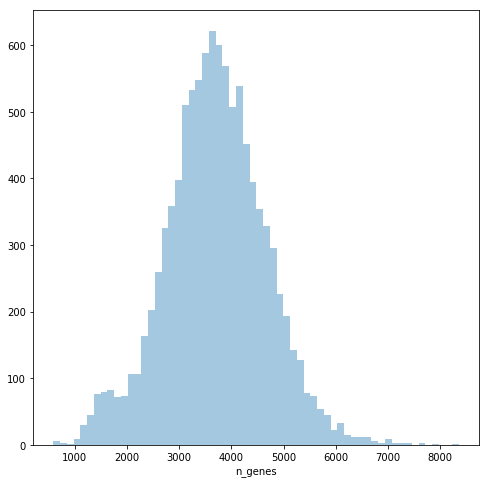

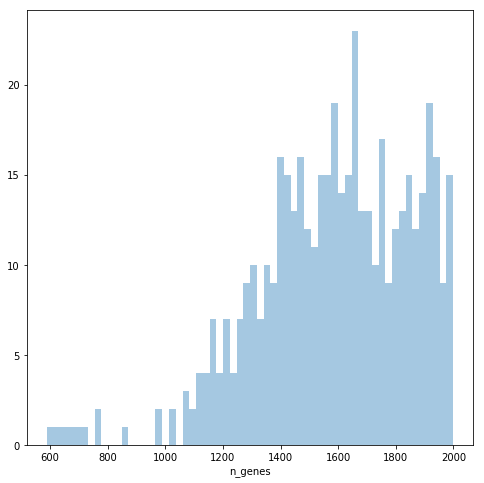

In [13]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=60)
plt.show()


Gene thresholding at < 1000 genes. This will filter out only few cells, but these appear to be strong outliers.

In [14]:
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 39000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 10313
filtered out 49 cells that havemore than 39000 counts
Number of cells after max count filter: 10264
Number of cells after MT filter: 10250
filtered out 10 cells that haveless than 1000 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 10240


In [15]:
#Filter cells according to ambiguous reads and doublets
print('Total number of cells: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['Demux_state'] == 'SNG', :]
print('Number of cells after demux filter: {:d}'.format(adata.n_obs))


Total number of cells: 10240
Number of cells after demux filter: 10240


In [16]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 58735
filtered out 38112 genes that are detectedin less than 20 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 20623


# Normalization

In [17]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [18]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [19]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [20]:
#Delete adata_pp
del adata_pp

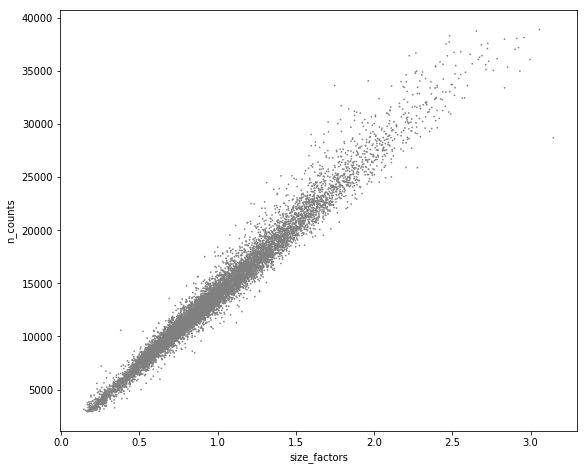

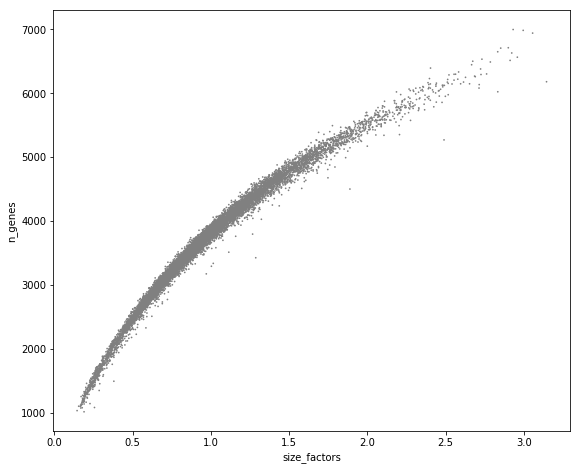

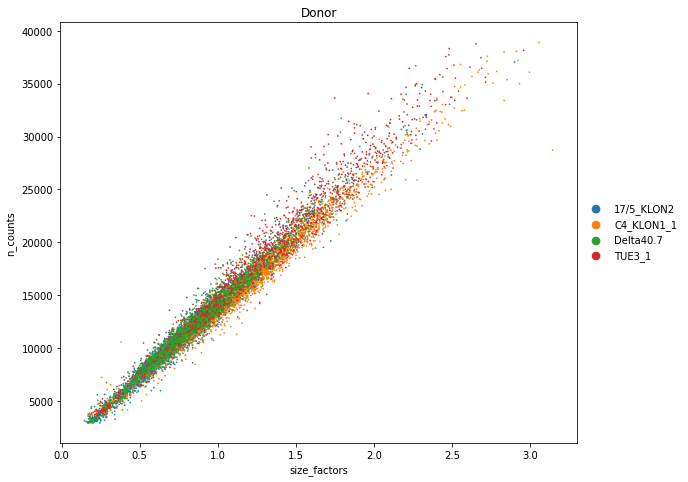

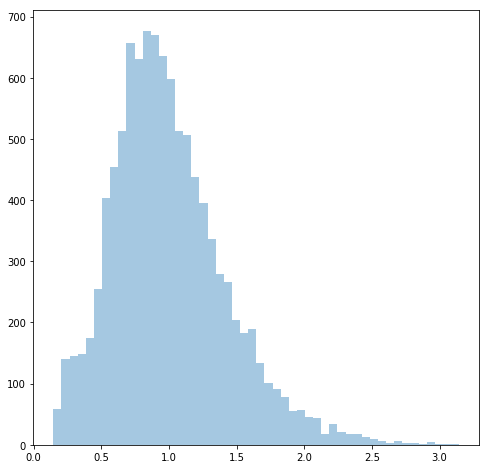

In [42]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')
sc.pl.scatter(adata, 'size_factors', 'n_counts', color="Donor")

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

In [22]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [23]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [24]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

# Highly Variable Genes

In [25]:
# Check highly variable gene selection to look at the results
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


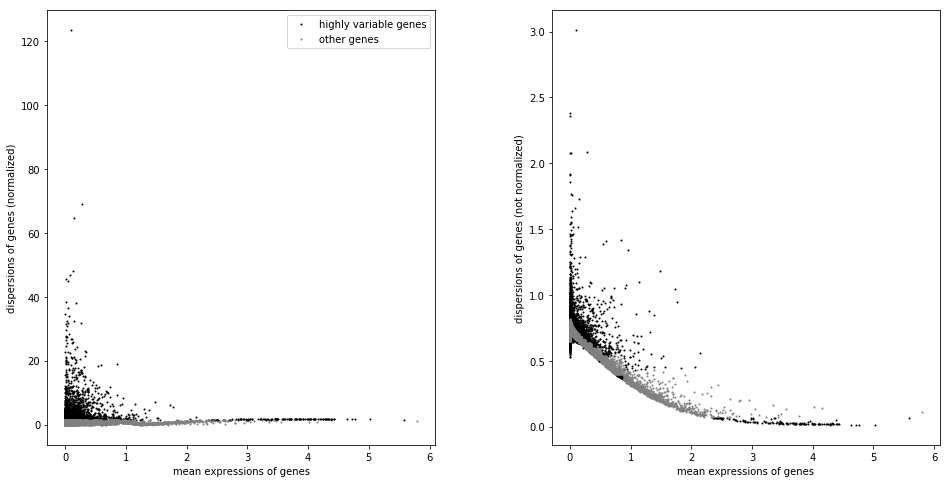

In [26]:
#Plot the highly variable genes
sc.pl.highly_variable_genes(adata)

# Dimensionality reduction (summarization)

In [27]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)


# Look at some plots (pre-mnn)

In [28]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:09)


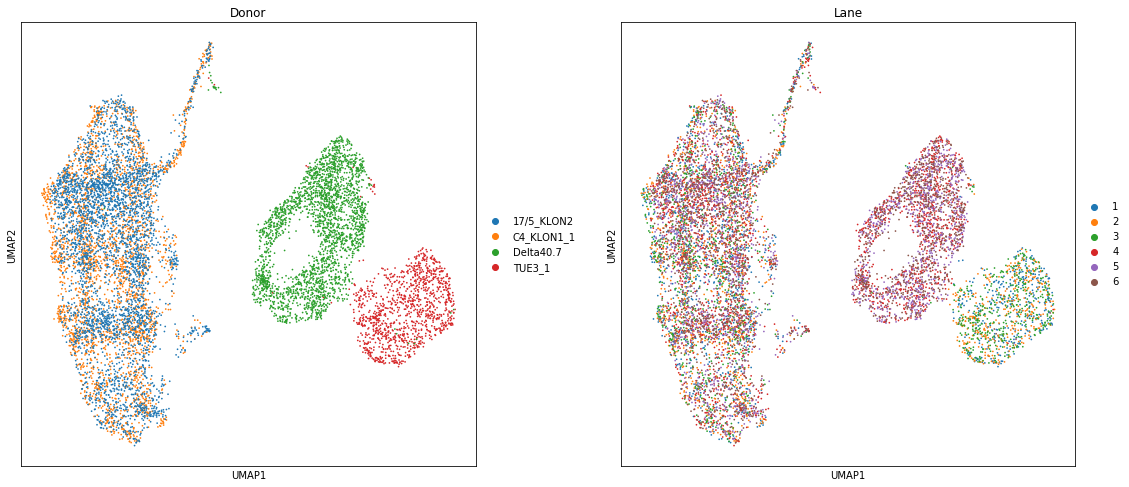

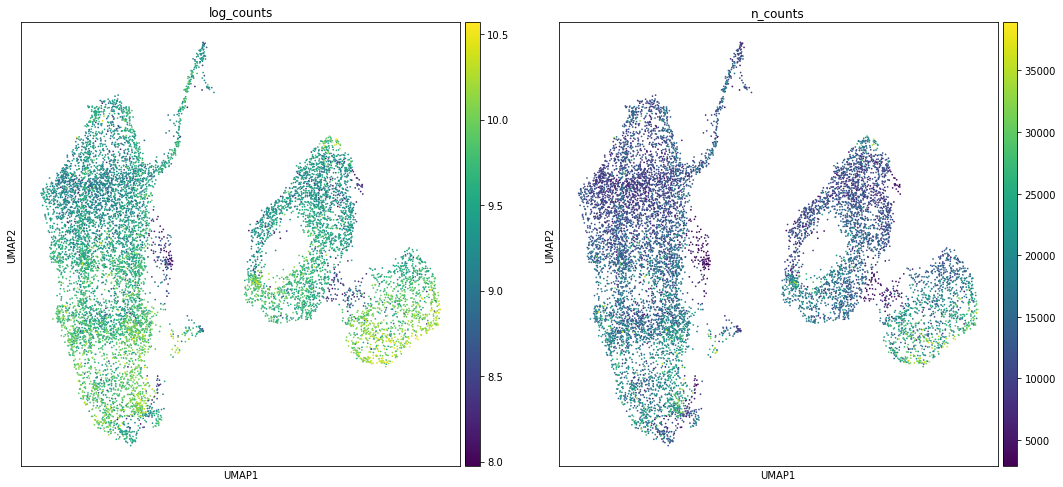

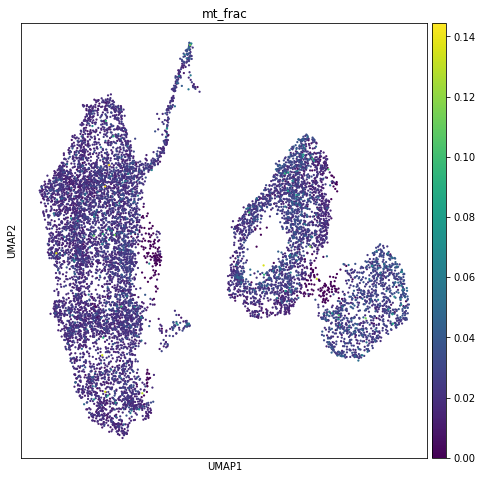

In [39]:
sc.pl.umap(adata, color=['Donor', 'Lane'], wspace=0.2)
sc.pl.umap(adata, color=['log_counts', 'n_counts'])
sc.pl.umap(adata, color='mt_frac', size=20)

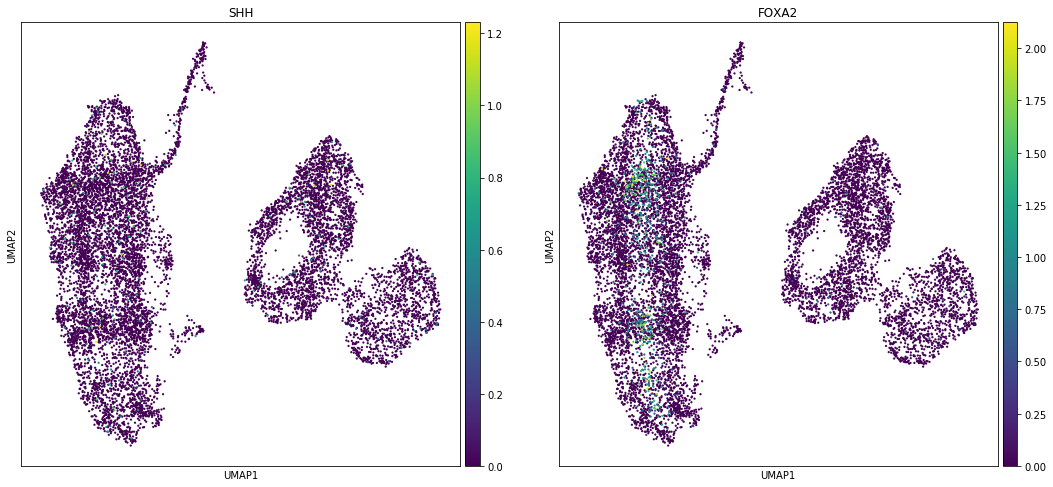

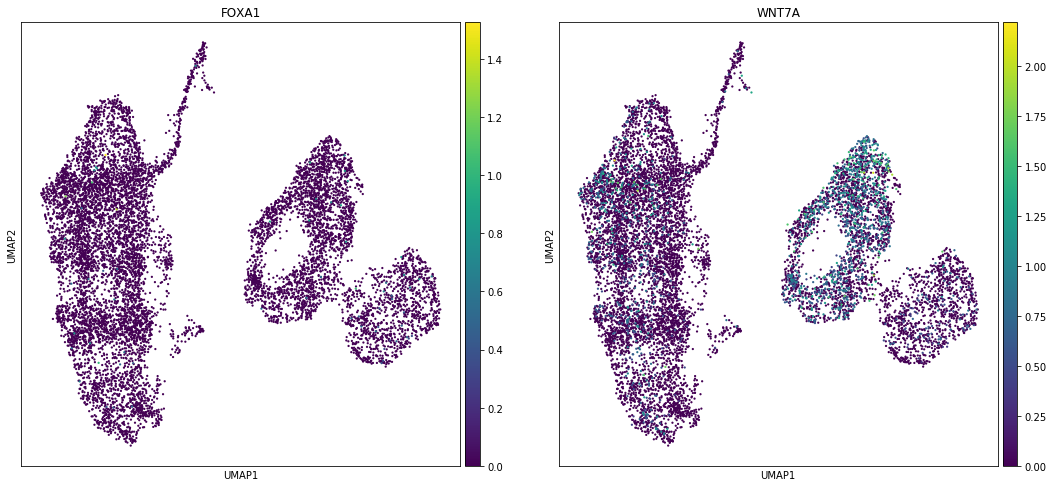

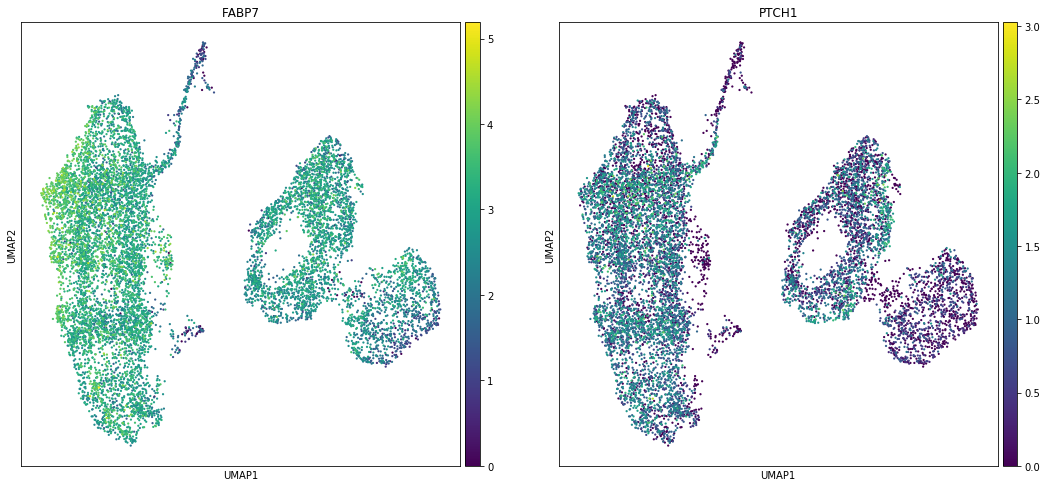

In [33]:
sc.pl.umap(adata, color=['SHH', 'FOXA2'], size=20)
sc.pl.umap(adata, color=['FOXA1', 'WNT7A'], size=20)
sc.pl.umap(adata, color=['FABP7', 'PTCH1'], size=20)

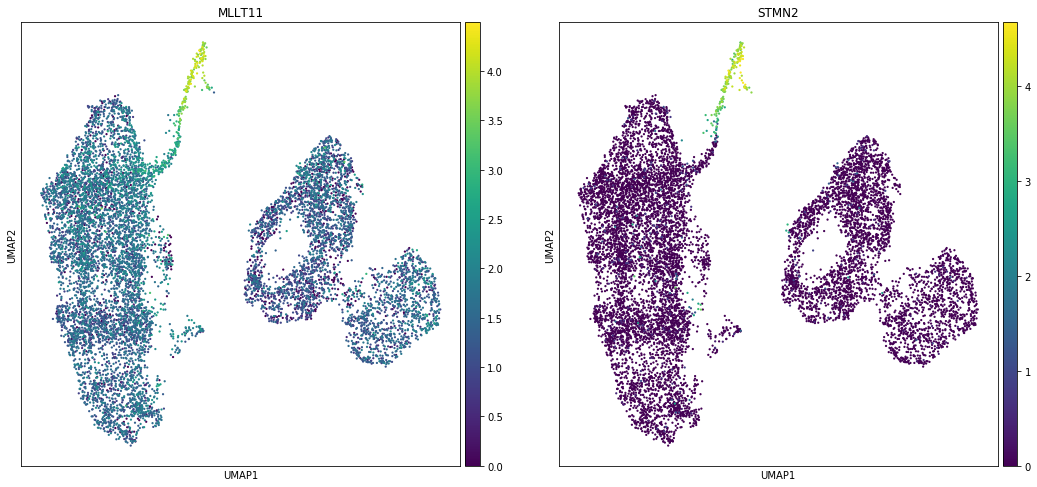

In [41]:
#Immature neuron markers
sc.pl.umap(adata, color=['MLLT11', 'STMN2'], size=20)

Notes:
- '17/5_KLON2' and 'C4_KLON1_1' mix well
- 'Delta40.7' and 'TUE3_1' look very distinct and may require MNN integration.
- SHH and WNT separation is not as clear in this dataset.

Questions:
- should these cell lines have the same cell types? 
  -  Some, yes. But different reprogramming methods, so maybe no point in joining the datasets.
- how much biological variability should be shared? 
  - Should be some, but unclear whether comparison between data pairs makes sense.

# Cell cycle

In [37]:
#Score cell cycle and visualize the effect:
cell_cycle_genes = [x.strip() for x in open(cc_genes_tirosh)]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:03)
computing score 'G2M_score'
    finished (0:00:03)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


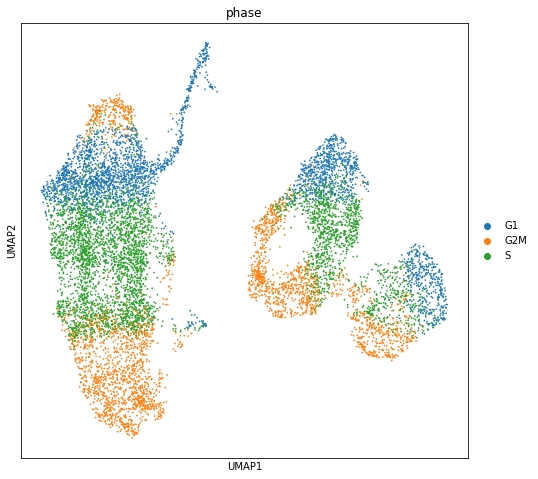

In [38]:
# Tirosh CC gene scoring
sc.pl.umap(adata, color='phase')

# Separate the data (not-integrated)

In [70]:
adata.obs.Donor.value_counts()

Pink1_mut         3718
Pink1_mut_ctrl    2851
Pink1_ko          2529
Pink1_ko_ctrl     1142
Name: Donor, dtype: int64

In [72]:
adata_int = adata[[don in ['internal_1', 'internal_2'] for don in adata.obs.Donor]].copy()
adata_int
adata_int.obs.Donor.value_counts()

AnnData object with n_obs × n_vars = 6569 × 20623 
    obs: 'Demux_state', 'Donor', 'Lane', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'pca', 'neighbors', 'Lane_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

Pink1_mut         3718
Pink1_mut_ctrl    2851
Name: Donor, dtype: int64

In [73]:
adata_ko = adata[[don in ['Pink1_ko', 'Pink1_ko_ctrl'] for don in adata.obs.Donor]].copy()
adata_ko
adata_ko.obs.Donor.value_counts()

AnnData object with n_obs × n_vars = 3671 × 20623 
    obs: 'Demux_state', 'Donor', 'Lane', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'pca', 'neighbors', 'Lane_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

Pink1_ko         2529
Pink1_ko_ctrl    1142
Name: Donor, dtype: int64

These separate datsets were normalized together. This should be fine. Feature selection (HVGs) will however be performed again for them separately.

# HVG selection

In [75]:
# Check highly variable gene selection to look at the results
sc.pp.highly_variable_genes(adata_int, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_int.var['highly_variable'])))

# Check highly variable gene selection to look at the results
sc.pp.highly_variable_genes(adata_ko, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_ko.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


# Visualization

In [76]:
sc.pp.pca(adata_int, n_comps=50, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata_int)

sc.pp.pca(adata_ko, n_comps=50, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata_ko)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [77]:
sc.tl.umap(adata_int)
sc.tl.umap(adata_ko)

computing UMAP
    finished (0:00:14)
computing UMAP
    finished (0:00:07)


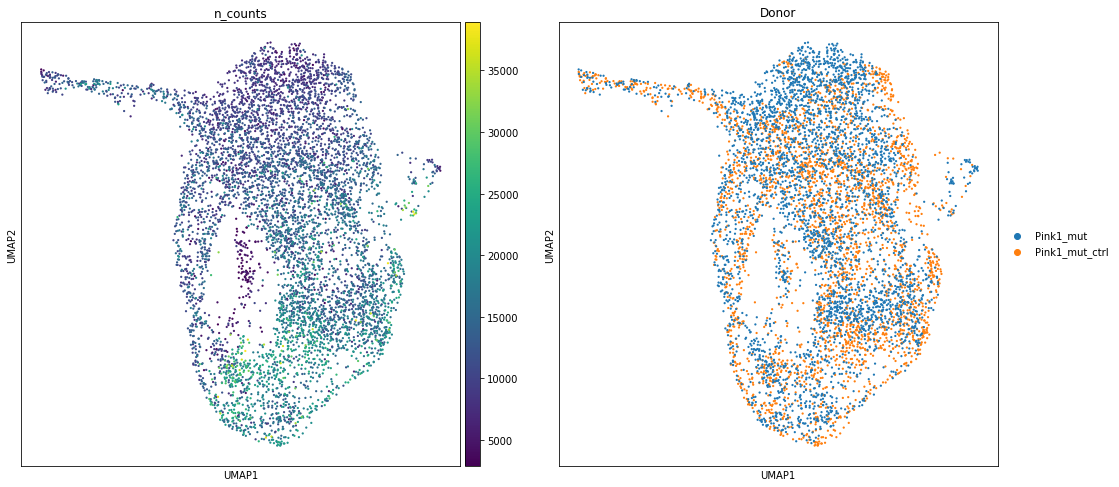

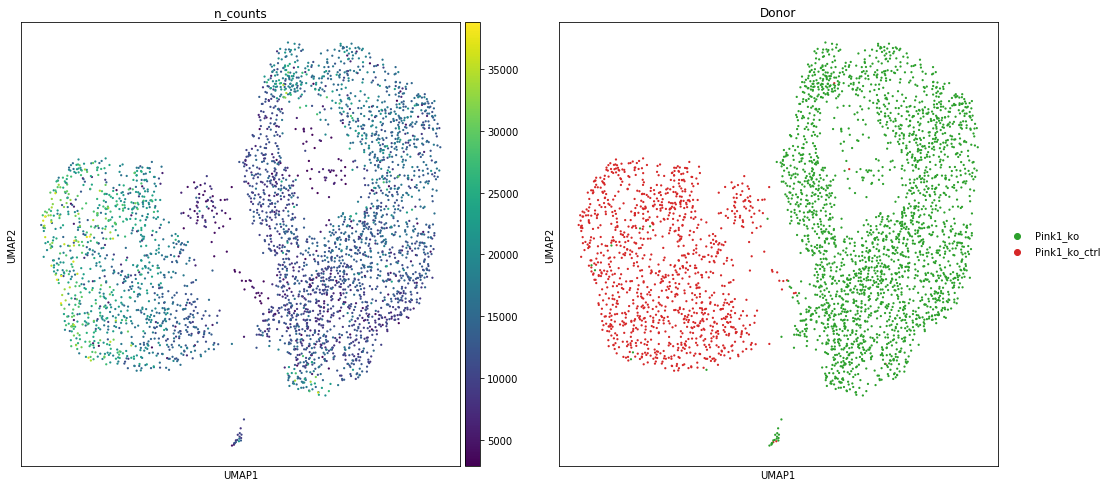

In [78]:
sc.pl.umap(adata_int, color=['n_counts', 'Donor'], size=20)
sc.pl.umap(adata_ko, color=['n_counts', 'Donor'], size=20)

Notes:
- it looks as though there is a conserved structure in the internal cell lines
- the Pink1 knockout cell lines may require further integration

# Output data

In [34]:
adata.write(adata_output)

In [81]:
adata_int.write(adata_output_int)
adata_ko.write(adata_output_ko)

# Some stats

In [4]:
adata = sc.read(adata_output)
adata.obs.Donor.value_counts()

17/5_KLON2    3718
C4_KLON1_1    2851
Delta40.7     2529
TUE3_1        1142
Name: Donor, dtype: int64

In [5]:
adata.obs['total_counts'] = adata.layers['counts'].sum(1)
adata.obs.groupby(by='Donor')['total_counts'].median()

Donor
17/5_KLON2    11105.0
C4_KLON1_1    15598.0
Delta40.7     12509.0
TUE3_1        19151.0
Name: total_counts, dtype: float32